### Question about how belief state value is distributed across sessions. Is there any bias in terms of previous correct vs. incorrect that could explain the differences in decoding observed?

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

In [10]:
num_bins = 10

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    beh["PrevResponse"] = beh.Response.shift()
    beh = beh[~beh.PrevResponse.isna()]
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    med = beh.BeliefStateValue.median()
    beh["BeliefStateValueBin"] = beh.apply(lambda x: 0 if x.BeliefStateValue < med else 1, axis=1)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["BeliefLabel"] = beh.apply(lambda x: f"High Value Pref {x.PreferredBelief}" if x.BeliefStateValueBin == 1 else "Low Value", axis=1)
    beh["session"] = session
    return beh

In [11]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))

### Distribution of belief state value

<Axes: xlabel='BeliefStateValue', ylabel='Count'>

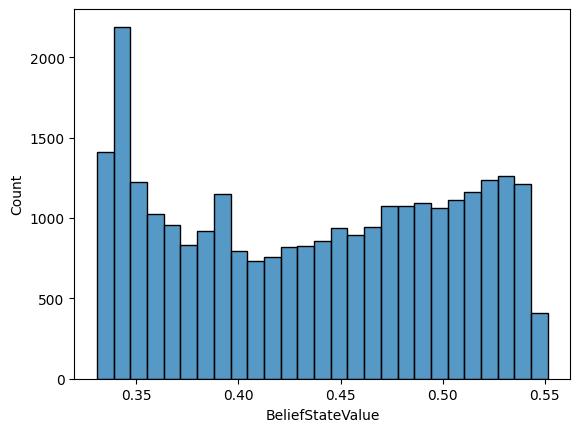

In [12]:
sns.histplot(data=res, x="BeliefStateValue")


### By labels, prev response, then labels conditioned on prev responses

Text(0.5, 1.0, 'By labels, cond prev_response = Incorrect')

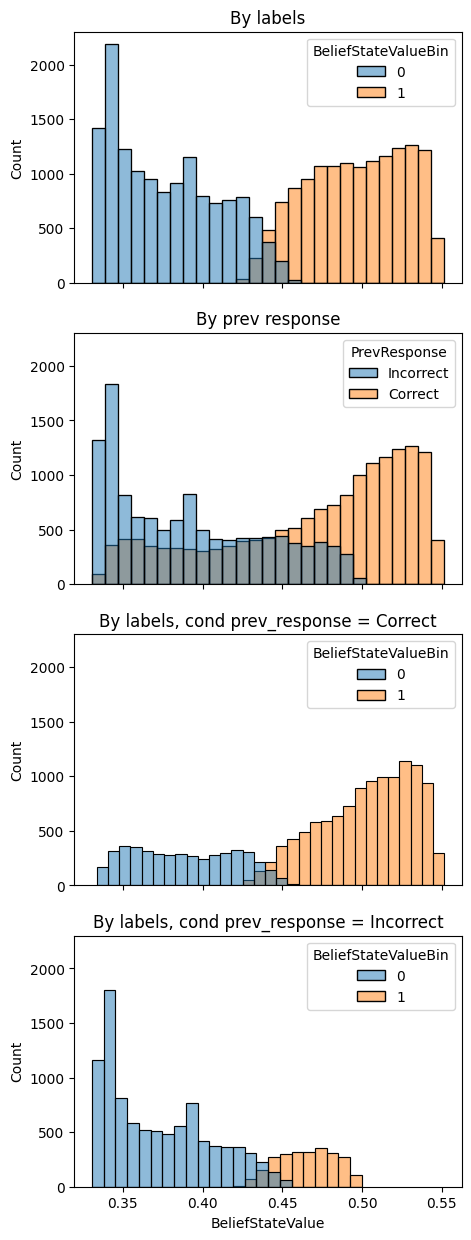

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(5, 15), sharex=True, sharey=True)
ax = axs[0]
sns.histplot(data=res, x="BeliefStateValue", hue="BeliefStateValueBin", ax=ax)
ax.set_title("By labels")

ax = axs[1]
sns.histplot(data=res, x="BeliefStateValue", hue="PrevResponse", ax=ax)
ax.set_title("By prev response")

ax = axs[2]
sub_res = res[res.PrevResponse == "Correct"]
sns.histplot(data=sub_res, x="BeliefStateValue", hue="BeliefStateValueBin", ax=ax)
ax.set_title("By labels, cond prev_response = Correct")

ax = axs[3]
sub_res = res[res.PrevResponse == "Incorrect"]
sns.histplot(data=sub_res, x="BeliefStateValue", hue="BeliefStateValueBin", ax=ax)
ax.set_title("By labels, cond prev_response = Incorrect")